<a href="https://colab.research.google.com/github/wj-arit/DenseNet121-with-PyTorch/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -lh /content


total 17G
drwx------ 5 root root 4.0K Nov 13 02:50 drive
-rw-r--r-- 1 root root  17G Nov 12 14:04 imagenet100.tar.gz
drwxr-xr-x 1 root root 4.0K Nov 11 14:29 sample_data


In [ ]:
!tar -xzf /content/imagenet100.tar.gz -C /content/
 #extract file
#!gdown --fuzzy 1UTjA-1Tzx3LXBDtMCQed4Q-qTLfQb06I




Train classes: 100
Val classes: 100
Train images: 130000
Val images: 5000


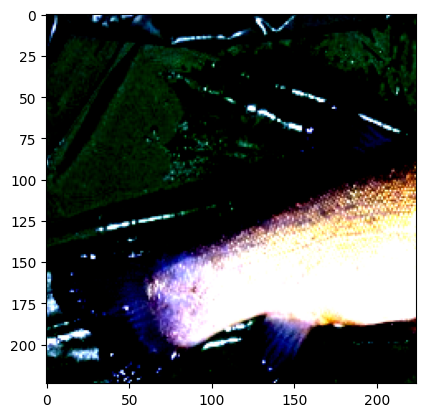

In [ ]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/content/train',transform=train_transform)
val_dataset = datasets.ImageFolder('/content/val',transform=val_transform)

batch_size = 256
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

if __name__ == '__main__':
    print("Train classes:", len(train_dataset.classes))
    print("Val classes:", len(val_dataset.classes))
    print("Train images:", len(train_dataset))
    print("Val images:", len(val_dataset))
    image,label = train_dataloader.dataset[2]
    plt.imshow(image.permute(1,2,0))
    plt.show()



In [ ]:
import torch.nn as nn
import torch

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate # bottle neck output
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels,inner_channels,kernel_size=1,stride=1,bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inner_channels,growth_rate, kernel_size=3,stride=1,padding=1, bias=False)

    def forward(self,x):
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        out = torch.cat([x,out],dim=1) # concatenation
        return out

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(DenseLayer((in_channels + i * growth_rate),growth_rate))

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransitionLayer(nn.Module):
    def __init__(self,in_channels,compression_rate=0.5):
        super().__init__()
        out_channels = int(in_channels * compression_rate)
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,bias=False)
        self.avg_pool = nn.AvgPool2d(kernel_size=2,stride=2)

    def forward(self,x):
        out = self.bn(x)
        out = self.relu(out)
        out = self.conv(out)
        out = self.avg_pool(out)
        return out

class DenseNet(nn.Module):
    def __init__(self,growth_rate=32,compression_rate=0.5,num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Dense Block 1
        num_channels = 64
        self.block1 = DenseBlock(6, num_channels, growth_rate)
        num_channels = num_channels + 6 * growth_rate  # 256
        self.transition1 = TransitionLayer(num_channels, compression_rate)
        num_channels = int(num_channels * compression_rate)  # 128

        # Dense Block 2
        self.block2 = DenseBlock(12, num_channels, growth_rate)
        num_channels = num_channels + 12 * growth_rate  # 128 + 384 = 512
        self.transition2 = TransitionLayer(num_channels, compression_rate)
        num_channels = int(num_channels * compression_rate)  # 256

        # Dense Block 3
        self.block3 = DenseBlock(24, num_channels, growth_rate)
        num_channels = num_channels + 24 * growth_rate  # 256 + 768 = 1024
        self.transition3 = TransitionLayer(num_channels, compression_rate)
        num_channels = int(num_channels * compression_rate)  # 512

        # Dense Block 4
        self.block4 = DenseBlock(16, num_channels, growth_rate)
        num_channels = num_channels + 16 * growth_rate  # 512 + 512 = 1024

        # Classifier
        self.bn_final = nn.BatchNorm2d(num_channels)
        self.relu_final = nn.ReLU(inplace=True)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, num_classes)

        # weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.max_pool(out)

        out = self.block1(out)
        out = self.transition1(out)
        out = self.block2(out)
        out = self.transition2(out)
        out = self.block3(out)
        out = self.transition3(out)
        out = self.block4(out)

        out = self.bn_final(out)
        out = self.relu_final(out)
        out = self.gap(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
import torch
from tqdm import tqdm
def train_one_epoch(model,dataloader,optimizer,criterion,device):
    model.train()
    total_correct = 0
    total_loss = 0.0
    total = len(train_dataloader.dataset)
    loop = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epo+1}")
    for x_batch, y_batch in loop:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # logit(output)
        y_hat = model(x_batch)
        # loss(cross_entropy)
        loss = criterion(y_hat, y_batch)
        # initialize gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # update parameters
        optimizer.step()

        # calculate batch_loss
        batch_loss = loss.item() * x_batch.size(0)
        total_loss += batch_loss

        # prediction in train
        preds = torch.argmax(y_hat,dim=1) # indices of high probability
        batch_correct = torch.sum(preds==y_batch).item()
        total_correct += batch_correct
    epoch_loss = total_loss / total
    epoch_accuracy = total_correct / total
    #print(f'train epoch loss: {epoch_loss} train epoch accuracy: {epoch_accuracy}')

    return epoch_loss, epoch_accuracy


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total = len(dataloader.dataset)
    total_loss = 0.0
    total_correct = 0
    desc = f"Valid (Epoch {epo+1})" if epo is not None else "Valid"
    loop = tqdm(dataloader, total=len(dataloader), desc=desc, leave=False)
    with torch.no_grad():
        for x_batch, y_batch in loop:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            batch_loss = loss.item() * x_batch.size(0)
            total_loss += batch_loss

            preds = torch.argmax(y_hat,1)
            correct = torch.sum(preds==y_batch).item()
            total_correct += correct

        val_loss = total_loss/total
        val_accuracy = total_correct/total
        #print(f'validation loss: {val_loss} validation accuracy: {val_accuracy}')
        return val_loss, val_accuracy


In [ ]:
import torch
import torch.nn as nn
#import train
import datasets
import pandas as pd

#from model import DenseNet

# hyper_parameters setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch = 90
model = DenseNet().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr = 0.1,momentum = 0.9,weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[30,60],0.1)
train_loader = train_dataloader
val_loader = val_dataloader
history = {
        'epoch': [],
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
best_val_loss = [0,float('inf')]
count = 0

#training
for epo in range(epoch):

    if epo == 0:
        print(f'device: {device}')
    # best val_loss compare
    train_loss, train_accuracy = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )

    val_loss, val_accuracy = validate_one_epoch(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device
    )
    scheduler.step()
    # result saving
    history['epoch'].append(epo+1)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print('-'*80)
    print(f'epoch: {epo+1} train_loss: {train_loss:4f} val_loss: {val_loss:4f} train_accuracy: {train_accuracy:4f} val_accuracy: {val_accuracy:4f}')

# extract best model
    if val_loss <= best_val_loss[1]:
        best_val_loss[0] = epo + 1
        best_val_loss[1] = val_loss
        count += 1

        # save model
        save_model_path = f'/content/best_model.pth'
        torch.save(model.state_dict(), save_model_path)
        print('save model complete')
        print(f'model change number: {count}')
        print(val_loss)
df = pd.DataFrame(history)
df.to_pickle('/content/training_log.pkl')
df.to_csv('/content/training_log.csv', index=False)
print('history saving complete')

device: cuda


Epoch 1: 100%|██████████| 508/508 [13:52<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 1 train_loss: 3.800704 val_loss: 3.215640 train_accuracy: 0.123915 val_accuracy: 0.213200
save model complete
model change number: 1
3.215639735412598


Epoch 2: 100%|██████████| 508/508 [13:51<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 2 train_loss: 2.992578 val_loss: 2.691200 train_accuracy: 0.269392 val_accuracy: 0.328400
save model complete
model change number: 2
2.691200382232666


Epoch 3: 100%|██████████| 508/508 [13:51<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 3 train_loss: 2.570589 val_loss: 2.431792 train_accuracy: 0.355623 val_accuracy: 0.387600
save model complete
model change number: 3
2.431791626358032


Epoch 4: 100%|██████████| 508/508 [13:47<00:00,  1.63s/it]


--------------------------------------------------------------------------------
epoch: 4 train_loss: 2.276074 val_loss: 2.381180 train_accuracy: 0.420085 val_accuracy: 0.419800
save model complete
model change number: 4
2.381179630279541


Epoch 5: 100%|██████████| 508/508 [13:48<00:00,  1.63s/it]


--------------------------------------------------------------------------------
epoch: 5 train_loss: 2.052818 val_loss: 2.188190 train_accuracy: 0.471115 val_accuracy: 0.451000
save model complete
model change number: 5
2.188189641189575


Epoch 6: 100%|██████████| 508/508 [13:49<00:00,  1.63s/it]


--------------------------------------------------------------------------------
epoch: 6 train_loss: 1.877471 val_loss: 1.947348 train_accuracy: 0.510408 val_accuracy: 0.507200
save model complete
model change number: 6
1.9473477853775025


Epoch 7: 100%|██████████| 508/508 [13:51<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 7 train_loss: 1.738166 val_loss: 1.867897 train_accuracy: 0.543215 val_accuracy: 0.527200
save model complete
model change number: 7
1.867896824836731


Epoch 8: 100%|██████████| 508/508 [13:53<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 8 train_loss: 1.623141 val_loss: 1.724284 train_accuracy: 0.569346 val_accuracy: 0.542800
save model complete
model change number: 8
1.7242841220855714


Epoch 9: 100%|██████████| 508/508 [13:53<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 9 train_loss: 1.522249 val_loss: 1.567786 train_accuracy: 0.595292 val_accuracy: 0.589400
save model complete
model change number: 9
1.5677863035202027


Epoch 10: 100%|██████████| 508/508 [13:55<00:00,  1.65s/it]


--------------------------------------------------------------------------------
epoch: 10 train_loss: 1.439427 val_loss: 1.490550 train_accuracy: 0.614246 val_accuracy: 0.602200
save model complete
model change number: 10
1.4905495656967163


Epoch 11: 100%|██████████| 508/508 [13:55<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 11 train_loss: 1.375275 val_loss: 1.584025 train_accuracy: 0.627746 val_accuracy: 0.608600


Epoch 12: 100%|██████████| 508/508 [13:56<00:00,  1.65s/it]


--------------------------------------------------------------------------------
epoch: 12 train_loss: 1.318352 val_loss: 1.306312 train_accuracy: 0.643200 val_accuracy: 0.648200
save model complete
model change number: 11
1.3063116378784179


Epoch 13: 100%|██████████| 508/508 [13:56<00:00,  1.65s/it]


--------------------------------------------------------------------------------
epoch: 13 train_loss: 1.270449 val_loss: 1.345484 train_accuracy: 0.654931 val_accuracy: 0.642400


Epoch 14: 100%|██████████| 508/508 [13:56<00:00,  1.65s/it]


--------------------------------------------------------------------------------
epoch: 14 train_loss: 1.229357 val_loss: 1.358567 train_accuracy: 0.665992 val_accuracy: 0.640600


Epoch 15: 100%|██████████| 508/508 [13:56<00:00,  1.65s/it]


--------------------------------------------------------------------------------
epoch: 15 train_loss: 1.195563 val_loss: 1.321192 train_accuracy: 0.672731 val_accuracy: 0.650400


Epoch 16: 100%|██████████| 508/508 [13:55<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 16 train_loss: 1.160236 val_loss: 1.364038 train_accuracy: 0.682638 val_accuracy: 0.635600


Epoch 17: 100%|██████████| 508/508 [13:54<00:00,  1.64s/it]


--------------------------------------------------------------------------------
epoch: 17 train_loss: 1.125562 val_loss: 1.191097 train_accuracy: 0.691238 val_accuracy: 0.672400
save model complete
model change number: 12
1.191097064971924


Epoch 18: 100%|██████████| 508/508 [13:55<00:00,  1.65s/it]


--------------------------------------------------------------------------------
epoch: 18 train_loss: 1.101668 val_loss: 1.137399 train_accuracy: 0.695877 val_accuracy: 0.696000
save model complete
model change number: 13
1.137399298095703


Epoch 19:  72%|███████▏  | 367/508 [10:04<03:56,  1.68s/it]

In [ ]:
!mv /content/best_model.pth /content/drive/MyDrive/best_model.pth
!mv /content/training_log.pkl /content/drive/MyDrive/DenseNet_log/training_log.pkl
!mv /content/training_log.csv /content/drive/MyDrive/DenseNet_log/training_log.csv
print("모든 로그/모델 파일 복사 완료.")

In [ ]:
!mv /content/best_model.pth /content/drive/MyDrive/DenseNet_best/best_model.pth

In [ ]:
!nvidia-smi


Thu Nov 13 03:23:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             53W /  400W |   36707MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
print(train_dataloader.dataset.root)
import time
start = time.time()
for i, (x, y) in enumerate(train_loader):
    print(f"첫 배치 로딩 완료, i={i}, {time.time()-start:.2f}s 걸림")
    break


/content/train
첫 배치 로딩 완료, i=0, 1.26s 걸림
